<a href="https://colab.research.google.com/github/HealMaDe/ViT_Patch_Trial/blob/main/Dermamnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

if torch.cuda.is_available():
    print("✅ GPU detected")
    print("Device name:", torch.cuda.get_device_name(0))
    print("Memory allocated:", round(torch.cuda.memory_allocated(0)/1024**2, 1), "MB")
    print("Memory reserved:", round(torch.cuda.memory_reserved(0)/1024**2, 1), "MB")
else:
    print("❌ No GPU detected, using CPU")


✅ GPU detected
Device name: Tesla T4
Memory allocated: 0.0 MB
Memory reserved: 0.0 MB


In [ ]:
import os, time, csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import timm
import numpy as np
from PIL import Image
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# -------------------------
# Setup
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
IMG_SIZE = 28  # original size
EPOCHS = 120
LR = 1e-4
DATA_PATH = "./dermamnist.npz"
SAVE_DIR = "./results_derma"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
model_name = "vit_tiny_patch16_224" # or vit_small_patch16_224, vit_base_patch16_224
patch_size = 28, #try  14,7,4,2,1

In [ ]:
# -------------------------
# Dataset
# -------------------------
class DermaMNISTDataset(Dataset):
    def __init__(self, split, npz_path=DATA_PATH, transform=None):
        data = np.load(npz_path)
        if split == "train":
            self.images, self.labels = data["train_images"], data["train_labels"]
        elif split == "val":
            self.images, self.labels = data["val_images"], data["val_labels"]
        elif split == "test":
            self.images, self.labels = data["test_images"], data["test_labels"]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

        self.labels = self.labels.reshape(-1)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]   # already RGB (H, W, 3)
        label = int(self.labels[idx])

        img = Image.fromarray((img * 255).astype(np.uint8))  # no need convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


# -------------------------
# augmentation
# -------------------------
train_transform = T.Compose([
    T.RandomResizedCrop(28, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),   # lesions can appear in any orientation
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    T.ToTensor()
])

val_transform = T.Compose([
    T.ToTensor()
])



train_ds = DermaMNISTDataset("train", transform=train_transform)
val_ds   = DermaMNISTDataset("val", transform=val_transform)
test_ds  = DermaMNISTDataset("test", transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES = len(set(train_ds.labels.flatten()))  # should be 7



def get_model(model_name="vit_base_patch16_224", patch_size=28, img_size=28):
    if isinstance(img_size, int):
        img_size = (img_size, img_size)
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=NUM_CLASSES,
        patch_size=patch_size,
        img_size=img_size
    )
    return model.to(DEVICE)

# ------------------------

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    t0 = time.time()
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE); labels = labels.long().to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    epoch_time = time.time() - t0
    return running_loss / total, correct / total, epoch_time



@torch.no_grad()
def evaluate(model, loader, criterion, save_csv=None):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds_class = []
    all_probs = []

    # sync for accurate timing on GPU
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    t0 = time.time()

    for imgs, labels in loader:
        imgs = imgs.to(DEVICE); labels = labels.long().to(DEVICE)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * imgs.size(0)
        preds_class = outputs.argmax(1)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds_class.extend(preds_class.cpu().numpy().tolist())
        # for binary: save prob of positive class; for multiclass save the whole row
        if probs.shape[1] == 2:
            all_probs.extend(probs[:, 1].tolist())          # (N,) list of positive prob
        else:
            all_probs.extend(probs.tolist())                # list of lists (N, C)

    if DEVICE == "cuda":
        torch.cuda.synchronize()
    elapsed = time.time() - t0
    fps = len(all_labels) / elapsed if elapsed > 0 else 0.0

    acc = np.mean(np.array(all_labels) == np.array(all_preds_class))
    bal_acc = balanced_accuracy_score(all_labels, all_preds_class)

    # compute AUC
    try:
        if NUM_CLASSES == 2:
            auc = roc_auc_score(all_labels, np.array(all_probs))  # probs is (N,) for positive class
        else:
            auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr', average='macro')
    except Exception as e:
        print("roc_auc_score error:", e)
        auc = 0.0

    # save predictions & probs
    if save_csv is not None:
        with open(save_csv, "w", newline="") as f:
            writer = csv.writer(f)
            if NUM_CLASSES == 2:
                writer.writerow(["label", "pred_class", "prob_pos"])
                for y, phat, ppos in zip(all_labels, all_preds_class, all_probs):
                    writer.writerow([y, phat, ppos])
            else:
                writer.writerow(["label", "pred_class"] + [f"prob_{i}" for i in range(NUM_CLASSES)])
                for y, phat, probs_row in zip(all_labels, all_preds_class, all_probs):
                    writer.writerow([y, phat] + probs_row)

    return running_loss / len(loader.dataset), acc, bal_acc, auc, elapsed, fps


def run_experiment(model_name, patch_size):
    print(f"\n===== Training {model_name} with patch size {patch_size} (input {IMG_SIZE}) =====")
    model = get_model(model_name, patch_size=patch_size, img_size=IMG_SIZE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

    # StepLR scheduler (reduce LR by 0.5 every 30 epochs) ---
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

    history = {"train_loss": [], "train_acc": [],
               "val_loss": [], "val_acc": [], "val_auc": []}

    best_val_loss = float("inf")   # track best by validation loss
    best_ckpt = None

    # reset peak memory statistics only if CUDA available
    if DEVICE == "cuda":
        torch.cuda.reset_peak_memory_stats()

    total_train_time = 0.0
    for epoch in range(1, EPOCHS+1):
        train_loss, train_acc, epoch_time = train_one_epoch(model, train_loader, optimizer, criterion)
        total_train_time += epoch_time
        val_loss, val_acc, val_bal_acc, val_auc, _, _ = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch}/{EPOCHS} "
              f"| LR {optimizer.param_groups[0]['lr']:.2e} "
              f"| Train loss {train_loss:.4f} acc {train_acc:.4f} "
              f"| Val loss {val_loss:.4f} acc {val_acc:.4f} bal_acc {val_bal_acc:.4f} auc {val_auc:.4f} "
              f"| epoch_time {epoch_time:.2f}s")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_auc"].append(val_auc)

        # --- Save best checkpoint by lowest validation loss ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_ckpt = f"{SAVE_DIR}/best_{model_name}_p{patch_size}_28.pth"
            torch.save(model.state_dict(), best_ckpt)

        # --- Step scheduler ---
        scheduler.step()

    # load best and evaluate on test set
    if best_ckpt is None:
        print("No checkpoint saved (no improvement). Using last model weights.")
        best_ckpt = f"{SAVE_DIR}/last_{model_name}_p{patch_size}_28.pth"
        torch.save(model.state_dict(), best_ckpt)

    model.load_state_dict(torch.load(best_ckpt, map_location=DEVICE))

    test_loss, test_acc, test_bal_acc, test_auc, test_time, fps = evaluate(
        model, test_loader, criterion,
        save_csv=f"{SAVE_DIR}/preds_{model_name}_p{patch_size}_28.csv"
    )

    peak_vram_mb = torch.cuda.max_memory_allocated() / (1024**2) if DEVICE == "cuda" else "N/A"

    print("\n=== Final test results ===")
    print(f"Model: {model_name}  patch: {patch_size}  input: {IMG_SIZE}")
    print(f"Test loss: {test_loss:.4f}  acc: {test_acc:.4f}  bal_acc: {test_bal_acc:.4f}  auc: {test_auc:.4f}")
    print(f"Total train time: {total_train_time:.2f}s  Test time: {test_time:.2f}s  Inference FPS: {fps:.2f}")
    print(f"Peak VRAM (MB): {peak_vram_mb}\n")

    # --- Plot curves ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history["train_loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Loss"); plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history["train_acc"], label="Train")
    plt.plot(history["val_acc"], label="Val")
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history["val_auc"], label="Val AUC")
    plt.title("Validation AUC"); plt.xlabel("Epoch"); plt.legend()

    plt.tight_layout()
    plot_path = f"{SAVE_DIR}/curves_{model_name}_p{patch_size}_28.png"
    plt.savefig(plot_path)

    #plt.close()
    print(f"Saved training curves to {plot_path}")
    plt.show()



===== Training vit_tiny_patch16_224 with patch size 28 (input 28) =====


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1/120 | LR 1.00e-04 | Train loss 1.0809 acc 0.6648 | Val loss 0.9457 acc 0.6700 bal_acc 0.1456 auc 0.8410 | epoch_time 26.59s
Epoch 2/120 | LR 1.00e-04 | Train loss 1.0107 acc 0.6698 | Val loss 0.9145 acc 0.6690 bal_acc 0.1481 auc 0.8647 | epoch_time 25.80s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.9736 acc 0.6763 | Val loss 0.8764 acc 0.6740 bal_acc 0.1508 auc 0.8644 | epoch_time 25.19s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.9680 acc 0.6730 | Val loss 0.9100 acc 0.6810 bal_acc 0.1695 auc 0.8583 | epoch_time 25.26s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.9440 acc 0.6805 | Val loss 0.8997 acc 0.6690 bal_acc 0.1429 auc 0.8754 | epoch_time 25.13s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.9359 acc 0.6829 | Val loss 0.8808 acc 0.6710 bal_acc 0.2347 auc 0.8638 | epoch_time 25.39s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.9260 acc 0.6812 | Val loss 0.8496 acc 0.7029 bal_acc 0.2483 auc 0.8672 | epoch_time 25.23s
Epoch 8/120 | LR 1.00e-04 | Train loss 0.9113 acc 0.6880 | Val loss 0.8618 a

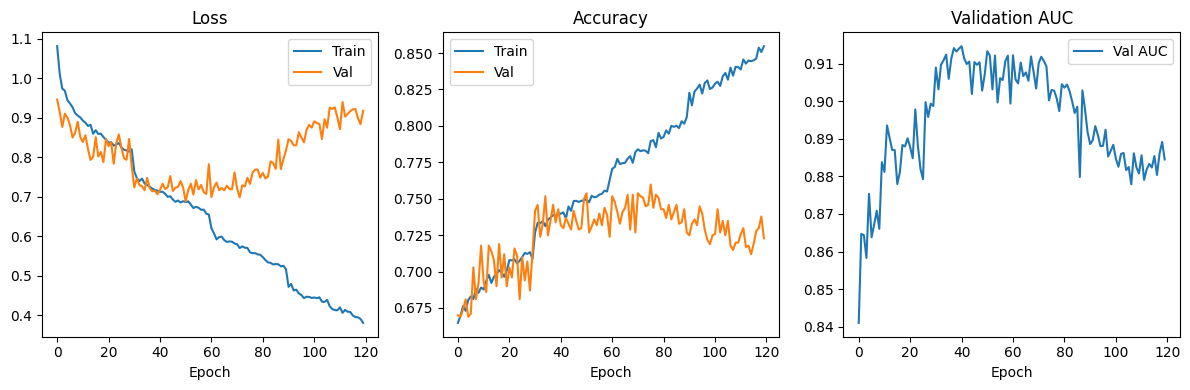


===== Training vit_tiny_patch16_224 with patch size 14 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 1.0386 acc 0.6649 | Val loss 0.9310 acc 0.6810 bal_acc 0.1751 auc 0.8516 | epoch_time 27.22s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.9571 acc 0.6753 | Val loss 0.8551 acc 0.6979 bal_acc 0.2208 auc 0.8606 | epoch_time 26.53s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.8962 acc 0.6862 | Val loss 0.8166 acc 0.7139 bal_acc 0.3155 auc 0.8982 | epoch_time 26.38s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.8637 acc 0.6957 | Val loss 0.7773 acc 0.7059 bal_acc 0.2565 auc 0.9027 | epoch_time 26.99s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.8499 acc 0.7010 | Val loss 0.7395 acc 0.7358 bal_acc 0.4002 auc 0.9082 | epoch_time 27.40s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.8208 acc 0.7083 | Val loss 0.7987 acc 0.6999 bal_acc 0.2351 auc 0.9018 | epoch_time 26.46s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.8081 acc 0.7109 | Val loss 0.7325 acc 0.7448 bal_acc 0.4307 auc 0.9153 | epoch_time 25.83s
Epo

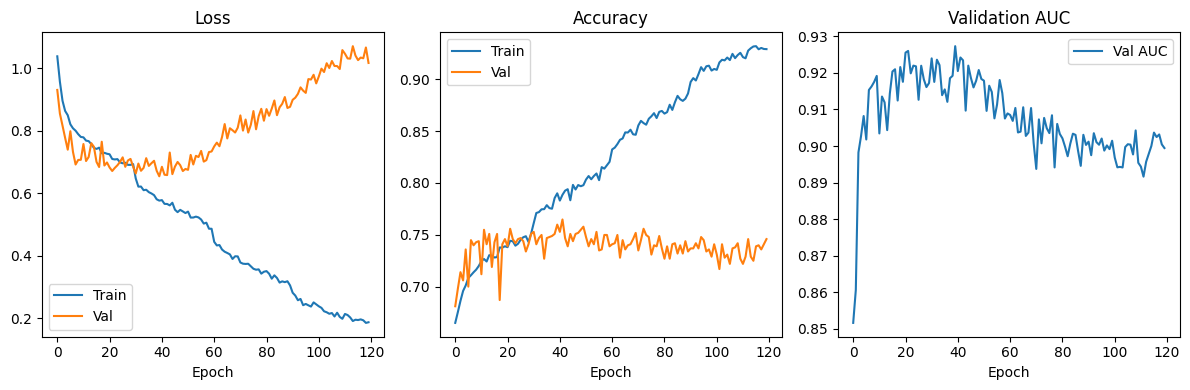


===== Training vit_tiny_patch16_224 with patch size 7 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.9344 acc 0.6827 | Val loss 0.8511 acc 0.7069 bal_acc 0.2867 auc 0.8803 | epoch_time 25.21s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.8231 acc 0.7081 | Val loss 0.7917 acc 0.7139 bal_acc 0.2493 auc 0.9030 | epoch_time 26.06s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.7870 acc 0.7204 | Val loss 0.7369 acc 0.7338 bal_acc 0.4320 auc 0.9201 | epoch_time 25.44s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.7773 acc 0.7228 | Val loss 0.6948 acc 0.7537 bal_acc 0.4146 auc 0.9247 | epoch_time 25.21s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.7469 acc 0.7370 | Val loss 0.7162 acc 0.7298 bal_acc 0.3258 auc 0.9213 | epoch_time 25.37s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.7384 acc 0.7387 | Val loss 0.7171 acc 0.7388 bal_acc 0.4240 auc 0.9214 | epoch_time 25.37s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.7230 acc 0.7398 | Val loss 0.6796 acc 0.7667 bal_acc 0.4553 auc 0.9248 | epoch_time 25.56s
Epoc

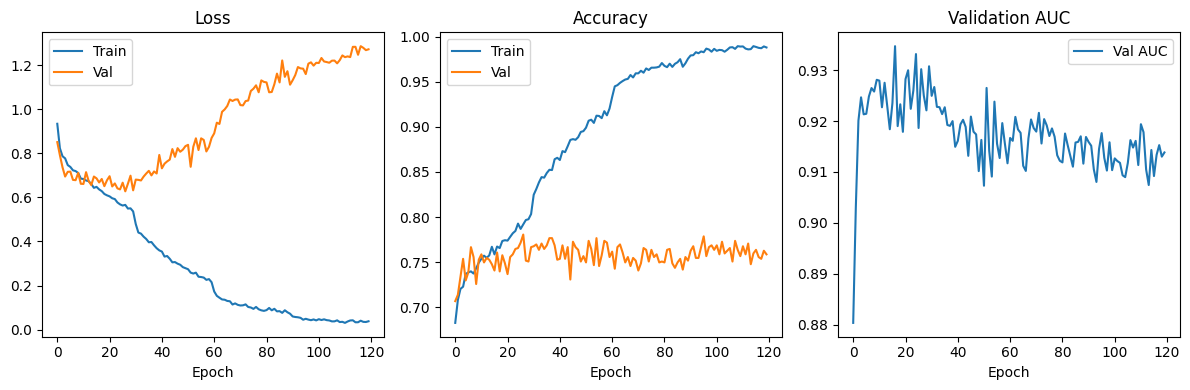


===== Training vit_tiny_patch16_224 with patch size 4 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.9333 acc 0.6863 | Val loss 0.7759 acc 0.7029 bal_acc 0.3888 auc 0.9115 | epoch_time 24.32s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.8044 acc 0.7140 | Val loss 0.7710 acc 0.7338 bal_acc 0.4181 auc 0.9084 | epoch_time 24.45s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.7669 acc 0.7287 | Val loss 0.6759 acc 0.7567 bal_acc 0.4428 auc 0.9283 | epoch_time 24.38s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.7405 acc 0.7331 | Val loss 0.6995 acc 0.7498 bal_acc 0.3894 auc 0.9202 | epoch_time 24.27s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.7184 acc 0.7383 | Val loss 0.6538 acc 0.7717 bal_acc 0.4600 auc 0.9312 | epoch_time 24.36s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.7083 acc 0.7427 | Val loss 0.6653 acc 0.7617 bal_acc 0.4823 auc 0.9282 | epoch_time 24.23s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.6941 acc 0.7460 | Val loss 0.6620 acc 0.7547 bal_acc 0.4266 auc 0.9305 | epoch_time 24.28s
Epoc

In [ ]:

if __name__ == "__main__":
    for p in [28,14,7,4,2,1]:
        run_experiment(model_name, patch_size=p)


===== Training vit_tiny_patch16_224 with patch size 4 (input 28) =====


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1/120 | LR 1.00e-04 | Train loss 0.9158 acc 0.6867 | Val loss 0.7747 acc 0.7049 bal_acc 0.2614 auc 0.9021 | epoch_time 30.77s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.7935 acc 0.7131 | Val loss 0.7152 acc 0.7228 bal_acc 0.3055 auc 0.9177 | epoch_time 31.11s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.7582 acc 0.7250 | Val loss 0.6771 acc 0.7507 bal_acc 0.4625 auc 0.9250 | epoch_time 29.42s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.7432 acc 0.7286 | Val loss 0.6790 acc 0.7468 bal_acc 0.4950 auc 0.9247 | epoch_time 29.95s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.7224 acc 0.7393 | Val loss 0.6877 acc 0.7617 bal_acc 0.4509 auc 0.9217 | epoch_time 29.49s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.7026 acc 0.7458 | Val loss 0.6521 acc 0.7577 bal_acc 0.4497 auc 0.9313 | epoch_time 29.46s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.6968 acc 0.7510 | Val loss 0.6392 acc 0.7597 bal_acc 0.4495 auc 0.9315 | epoch_time 29.82s
Epoch 8/120 | LR 1.00e-04 | Train loss 0.6908 acc 0.7478 | Val loss 0.6402 a

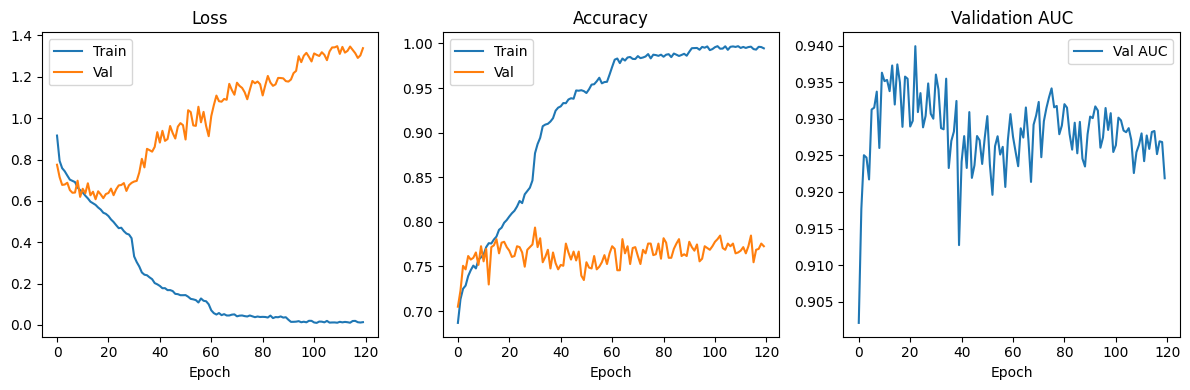

In [ ]:
if __name__ == "__main__":
    p = 4
    run_experiment(model_name, patch_size=p)


===== Training vit_tiny_patch16_224 with patch size 2 (input 28) =====


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1/120 | LR 1.00e-04 | Train loss 0.9820 acc 0.6759 | Val loss 0.8610 acc 0.7019 bal_acc 0.2353 auc 0.8965 | epoch_time 34.57s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.8081 acc 0.7144 | Val loss 0.6938 acc 0.7677 bal_acc 0.4625 auc 0.9221 | epoch_time 33.35s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.7669 acc 0.7257 | Val loss 0.6902 acc 0.7517 bal_acc 0.3589 auc 0.9218 | epoch_time 33.61s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.7490 acc 0.7277 | Val loss 0.6648 acc 0.7627 bal_acc 0.4694 auc 0.9254 | epoch_time 35.08s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.7239 acc 0.7400 | Val loss 0.8039 acc 0.7188 bal_acc 0.4477 auc 0.9230 | epoch_time 34.68s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.7083 acc 0.7455 | Val loss 0.6943 acc 0.7537 bal_acc 0.5387 auc 0.9232 | epoch_time 33.75s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.6941 acc 0.7430 | Val loss 0.6442 acc 0.7777 bal_acc 0.4697 auc 0.9327 | epoch_time 34.35s
Epoch 8/120 | LR 1.00e-04 | Train loss 0.6927 acc 0.7498 | Val loss 0.6600 a

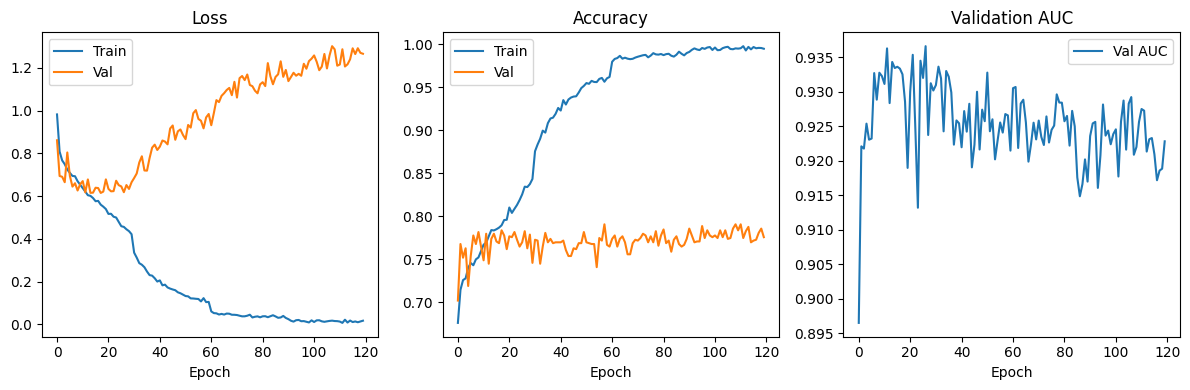


===== Training vit_tiny_patch16_224 with patch size 1 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.9588 acc 0.6775 | Val loss 0.8188 acc 0.7159 bal_acc 0.3473 auc 0.8968 | epoch_time 153.42s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.8283 acc 0.7084 | Val loss 0.7062 acc 0.7478 bal_acc 0.4741 auc 0.9178 | epoch_time 153.50s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.7858 acc 0.7187 | Val loss 0.7544 acc 0.7338 bal_acc 0.3822 auc 0.9151 | epoch_time 153.31s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.7675 acc 0.7211 | Val loss 0.7113 acc 0.7448 bal_acc 0.3176 auc 0.9185 | epoch_time 153.34s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.7416 acc 0.7358 | Val loss 0.6875 acc 0.7537 bal_acc 0.3906 auc 0.9209 | epoch_time 153.13s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.7317 acc 0.7360 | Val loss 0.6864 acc 0.7647 bal_acc 0.5021 auc 0.9305 | epoch_time 153.14s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.7086 acc 0.7454 | Val loss 0.7025 acc 0.7208 bal_acc 0.4762 auc 0.9253 | epoch_time 153.3

In [ ]:
if __name__ == "__main__":
    for p in [2,1]:
        run_experiment(model_name, patch_size=p)